In [1]:
# Let's import the needed packages for further use ! 
import sys,os

import numpy as np
import copy
import matplotlib.pyplot as plt
# %matplotlib notebook

plt.ioff()

import actynf

# A few helper functions ...
from tools import clever_running_mean
from tools import save_output,extract_training_data
from tools import to_list_of_one_hots
from tools import imshow_with_labels,plot_trials,plot_trials_and_data,plot_trials_new

# Loading the experimental measures !
from load_data import get_all_derivatives_in_order


# A FEW CONSTANTS : 
XP1_DATA_PATH = os.path.join("data_downloaded","xp1")



# Loading the experimental values we're trying to match
SUBJECT_NAMES,EEG_DATA,BOLD_DATA,TIMESTAMPS = get_all_derivatives_in_order(XP1_DATA_PATH)

In [2]:
timestamps_arr = np.array(TIMESTAMPS)
# Shape Nsubjects x Nruns x (Nblocks x2) x Nfeatures

print("EEG SHAPES ---------------------------------")
# Extract i-th component of the NF data : 
# In EEG-DATA : 
# These are the contents : [right_filtpower,left_filtpower,nf_laterality,nf_intensity,nf_intensity_smoothed,eeg_pp]
i = 0
for i in range(6):
    ith_component = np.array([[task_data[i] for task_data in s_data] for s_data in EEG_DATA])
    print(ith_component.shape) 
 
print("BOLD SHAPES ---------------------------------")
# Extract i-th component of the BOLD data : 
# In BOLD-DATA : 
#[right_filtpower,left_filtpower,bg_mean,nf_laterality,nf_laterality_norm,nf_laterality_smoothed,nf_intensity]
i = 0
for i in range(7):
    ith_component = np.array([[task_data[i] for task_data in s_data] for s_data in BOLD_DATA])
    print(ith_component.shape)
    
# Let's name the quantities we will use in this study :
# feedbacks as seen by the subject : 
BOLD_LATERALITY_FEEDBACK = np.array([[task_data[3] for task_data in s_data] for s_data in BOLD_DATA])
BOLD_INTENSITY_LEFT_ERD = np.array([[task_data[6] for task_data in s_data] for s_data in BOLD_DATA])

EEG_LATERALITY_FEEDBACK = np.array([[task_data[2] for task_data in s_data] for s_data in EEG_DATA])

NORM_LEFT_BP = np.array([[task_data[1] for task_data in s_data] for s_data in EEG_DATA]) # Normalized band power of the filtered EEG signal in C1 (LEFT)
EEG_INTENSITY_LEFT_ERD = np.array([[task_data[3] for task_data in s_data] for s_data in EEG_DATA]) # In XP2, the feedback was computed using only the lbp
EEG_INTENSITY_LEFT_ERD_SMOOTHED = np.array([[task_data[4] for task_data in s_data] for s_data in EEG_DATA]) # In XP2, the feedback was computed using only the lbp


EEG SHAPES ---------------------------------
(10, 3, 1600, 1)
(10, 3, 1600, 1)
(10, 3, 1600, 1)
(10, 3, 1600, 1)
(10, 3, 1600, 1)
(10, 3, 400, 200, 64)
BOLD SHAPES ---------------------------------
(10, 3, 200, 1)
(10, 3, 200, 1)
(10, 3, 200, 1)
(10, 3, 200, 1)
(10, 3, 200, 1)
(10, 3, 200, 1)
(10, 3, 200, 1)


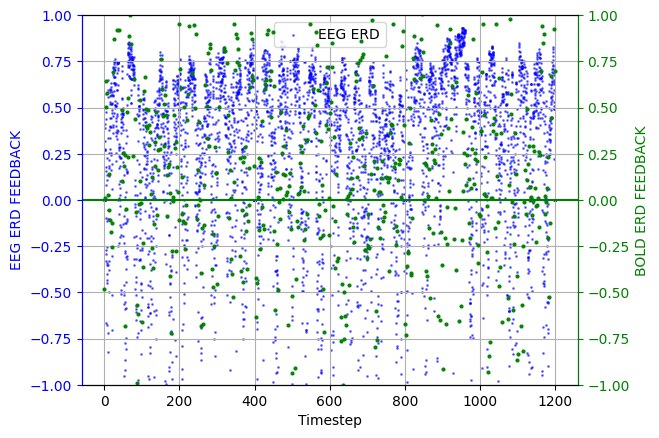

In [3]:
# ERD INTENSITY : EEG vs BOLD signal

# Get all the normed left BP successively :
norm_left_bp_flat = np.reshape(NORM_LEFT_BP,(10,-1))

# Get all erd intensity feedbacks (not shown!) successively : 
eeg_intensity_left_erd_flat = np.reshape(EEG_INTENSITY_LEFT_ERD,(10,-1))
bold_intensity_left_erd_flat = np.reshape(BOLD_INTENSITY_LEFT_ERD,(10,-1))

time_eeg = np.linspace(0,1200,eeg_intensity_left_erd_flat.shape[-1])
time_bold = np.linspace(0,1200,bold_intensity_left_erd_flat.shape[-1])



subj = 1

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Timestep")
ax.set_ylabel("EEG ERD FEEDBACK")
ax.scatter(time_eeg, eeg_intensity_left_erd_flat[subj],color="blue",alpha=0.5,s=1.0,label = 'EEG ERD')   
# ax.scatter(time[from_t:to_t], intensity_left_erd_smoothed_flat[subj,from_t:to_t],color="blue",alpha=0.5,s=1.0,label = 'Norm. BP in filtered EEG C1')  

ax.yaxis.label.set_color('blue')
ax.tick_params(axis='y', colors='blue')

ax2 = ax.twinx()
ax2.scatter(time_bold, bold_intensity_left_erd_flat[subj],color="green",s=4.0,alpha=0.95, label = 'BOLD ERD')
# ax2.scatter(time[from_t:to_t], intensity_left_erd_smoothed_flat[subj,from_t:to_t],color="red",s=1.0,alpha=0.95, label = 'Feedback based on left ERD intensity')
ax2.axhline(0.0,color="green")
ax.legend(loc="best")
ax.grid()

ax.yaxis.label.set_color('blue')
ax.tick_params(axis='y', colors='blue')
ax2.spines['left'].set_color('blue')

ax2.yaxis.label.set_color('green')
ax2.tick_params(axis='y', colors='green')
ax2.spines["right"].set_color('green')
ax2.set_ylabel("BOLD ERD FEEDBACK")


ax.set_ylim([-1,1.0])
ax2.set_ylim([-1,1.0])
plt.show()

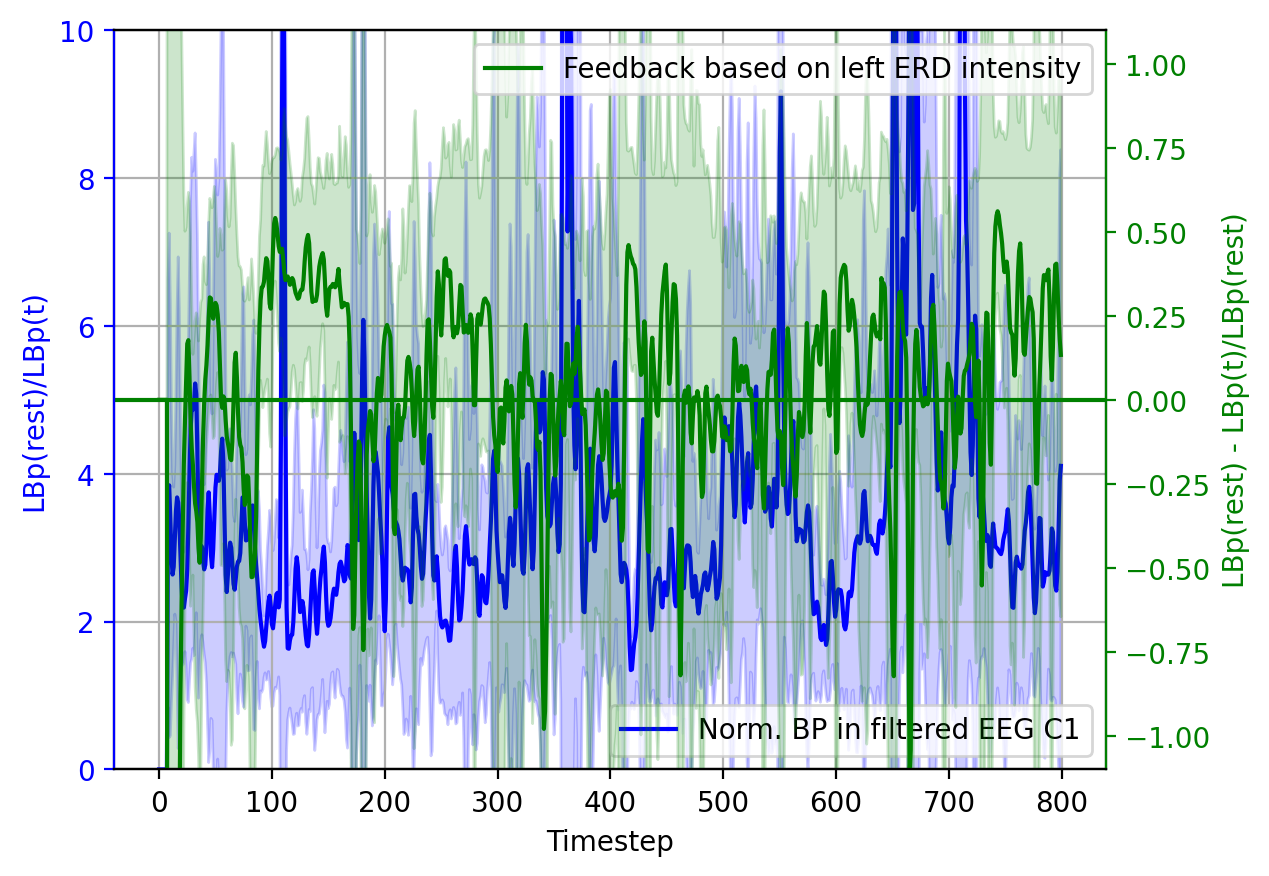

In [4]:
# Raw eeg_intensity_left_erd vs. bold_intensity_left_erd
intensity_left_erd_flat = np.reshape(EEG_INTENSITY_LEFT_ERD,(10,-1)) # Get all erd intensity computed from EEG BP (it was not shown to the subject !) 
norm_left_bp = np.reshape(NORM_LEFT_BP,(10,-1))

time = np.linspace(0,intensity_left_erd_flat.shape[-1],intensity_left_erd_flat.shape[-1])

subj = 1
from_t = 0
to_t = 800 + 0

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.set_xlabel("Timestep")
ax.set_ylabel("LBp(rest)/LBp(t)")
mean_left_bp = np.mean(norm_left_bp[:,from_t:to_t],axis=0)
std_left_bp = np.std(norm_left_bp[:,from_t:to_t],axis=0)
ax.fill_between(time[from_t:to_t],mean_left_bp-std_left_bp,mean_left_bp+std_left_bp,color="blue",alpha=0.2)   
ax.plot(time[from_t:to_t],mean_left_bp,color="blue",alpha=1.0,label = 'Norm. BP in filtered EEG C1')   
ax.set_ylim([0.0,10.0])

ax.yaxis.label.set_color('blue')
ax.tick_params(axis='y', colors='blue')

ax2 = ax.twinx()
mean_left_erd = np.mean(intensity_left_erd_flat[:,from_t:to_t],axis=0)
std_left_erd = np.std(intensity_left_erd_flat[:,from_t:to_t],axis=0)
ax2.fill_between(time[from_t:to_t],mean_left_erd-std_left_erd,mean_left_erd+std_left_erd,color="green",alpha=0.2)   
ax2.plot(time[from_t:to_t],mean_left_erd,color="green",alpha=1.0, label = 'Feedback based on left ERD intensity')   

ax.legend(loc="best")
ax2.legend()
ax.grid()

ax.yaxis.label.set_color('blue')
ax.tick_params(axis='y', colors='blue')
ax2.spines['left'].set_color('blue')
ax2.axhline(0.0,color="green")

ax2.yaxis.label.set_color('green')
ax2.tick_params(axis='y', colors='green')
ax2.spines["right"].set_color('green')
ax2.set_ylabel("LBp(rest) - LBp(t)/LBp(rest)")

ax2.set_ylim([-1.1,1.1])
plt.show()



For this study, we will use the feedback for XP2 based on the Left ERD intensity alone (in green above) as a marker for ERD intensity. We will also use the feedback shown to the subjects based on the lateralization of the ERD as a marker for ERD orientation :

C:\Users\annic\AppData\Local\Temp\ipykernel_7400\1389452358.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


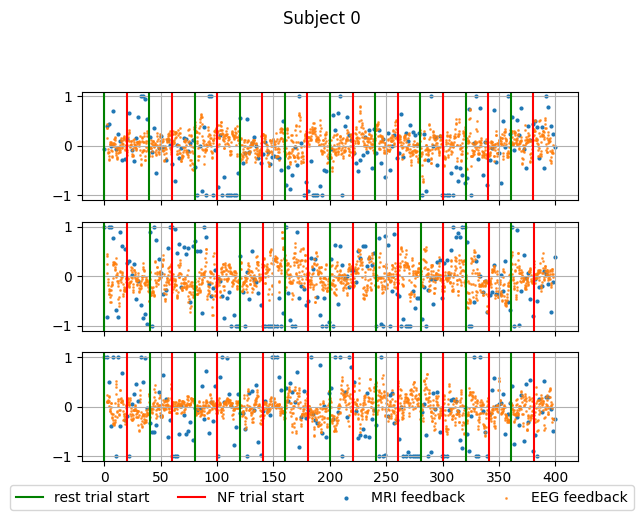

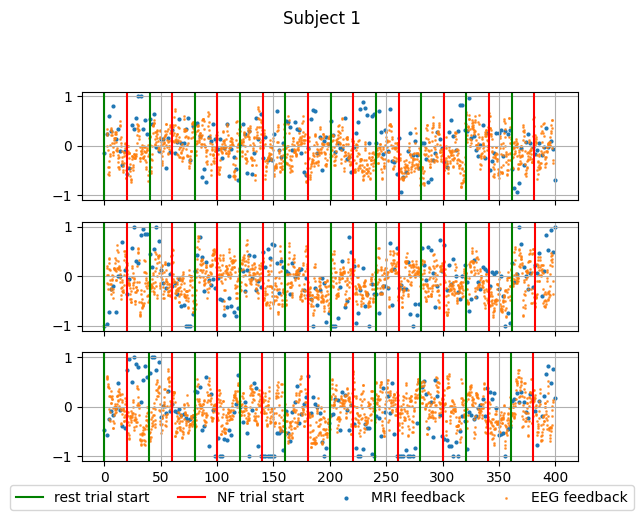

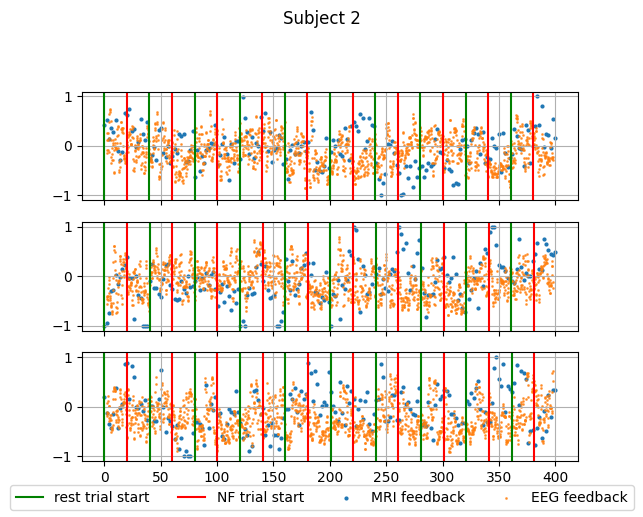

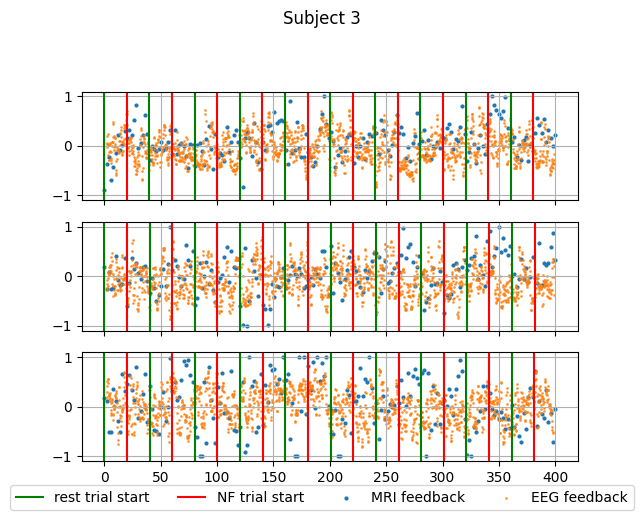

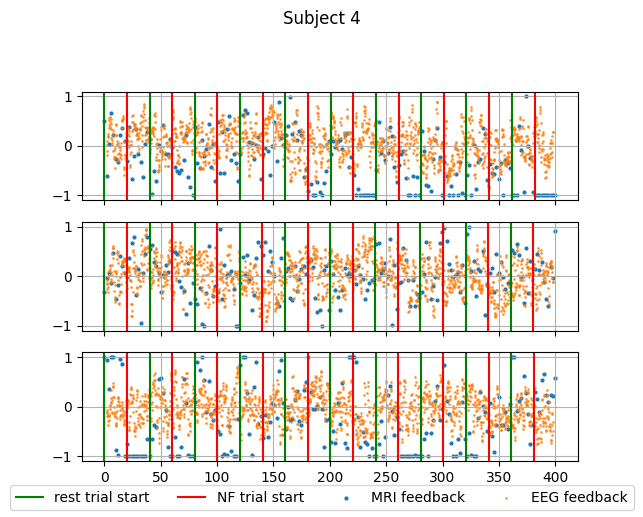

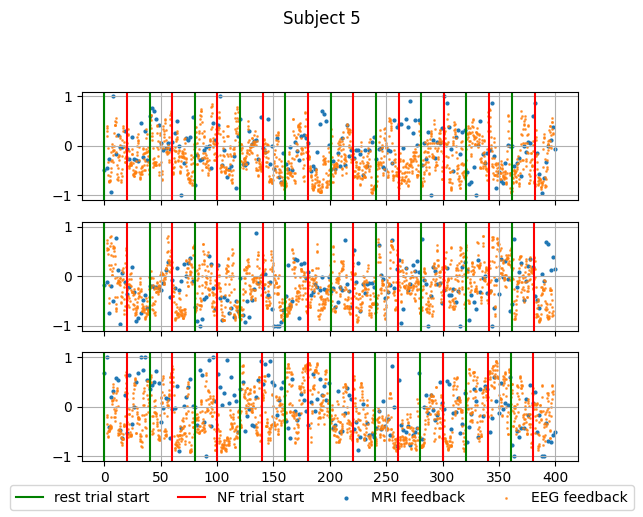

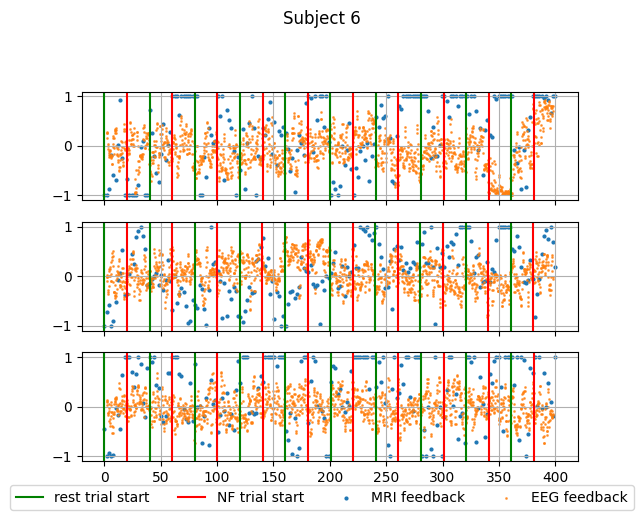

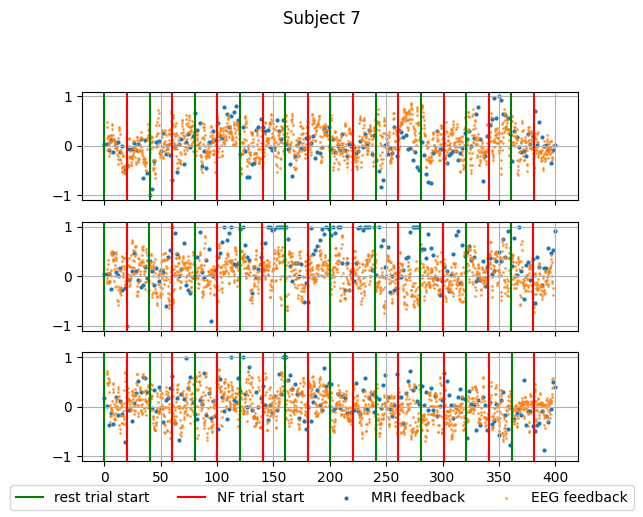

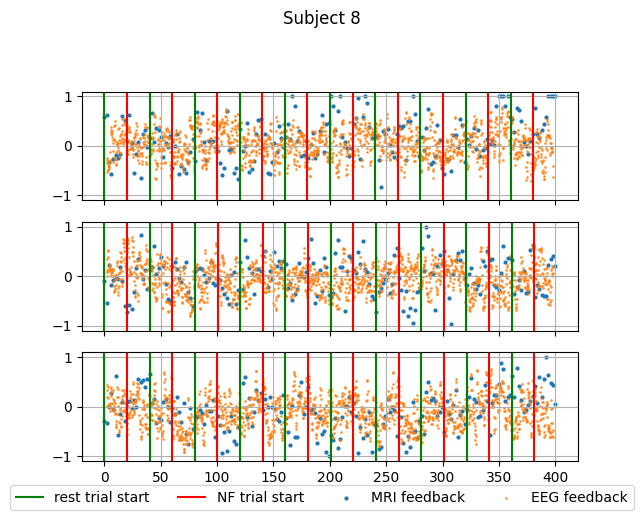

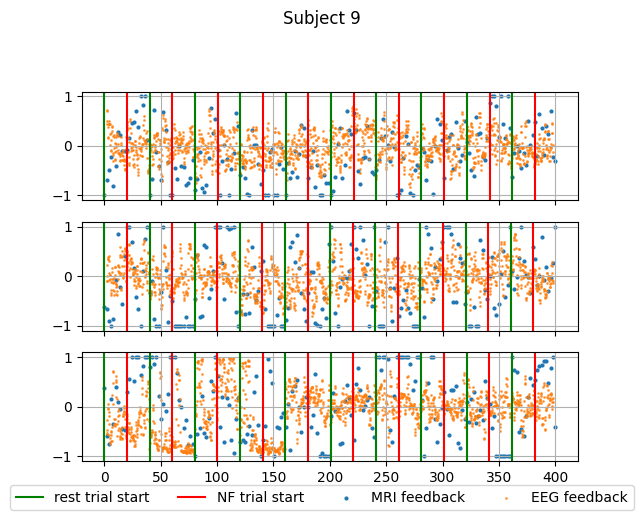

In [14]:
# Let's name the quantities we will use in this study :
# feedbacks as seen by the subject : (based on laterality !)
eeg_feedbacks = np.clip(EEG_LATERALITY_FEEDBACK,-1.0,1.0)
bold_feedbacks = np.clip(BOLD_LATERALITY_FEEDBACK,-1.0,1.0)



# # Normalized band power of the filtered EEG signal in C1 (LEFT)
# norm_left_bp = np.array([[task_data[1] for task_data in s_data] for s_data in EEG_DATA])

# # In XP2, the feedback was computed using only the lbp :
# intensity_left_erd = np.array([[task_data[3] for task_data in s_data] for s_data in EEG_DATA])

bold_flat = np.reshape(bold_feedbacks,(bold_feedbacks[...,0].shape[0],-1))
for subj in range(bold_feedbacks[...,0].shape[0]):
    fig,axes = plt.subplots(3,sharex=True)
    
    for task in range(bold_feedbacks[...,0].shape[1]) : 
        timestamps_task = timestamps_arr[subj,task,...]
        
        
        ax = axes[task]
        N_bold_data = bold_feedbacks[subj,task].shape[0]
        N_eeg_data = eeg_feedbacks[subj,task].shape[0]
        
        
        
        
        bold_time = np.linspace(0,400.0,N_bold_data)
        eeg_time = np.linspace(0,400.0,N_eeg_data) 
        
        lmri = ax.scatter(bold_time,bold_feedbacks[subj,task],s=4.0,label="MRI feedback")
        leeg = ax.scatter(eeg_time,eeg_feedbacks[subj,task],s=1.0,alpha=0.7,label="EEG feedback")
        
        for event in timestamps_task:
            if (event[0] - 0.0)<1e-3:
                color = "green"
                lab = "rest trial start"
                lrest = ax.axvline(event[2],color=color,label=lab)
            else : 
                color = "red"
                lab = "NF trial start"
                ltri = ax.axvline(event[2],color=color,label=lab)
        
        ax.set_ylim([-1.1,1.1])
        ax.grid()

    fig.suptitle("Subject {}".format(subj))
    handles = [lrest,ltri,lmri,leeg]
    labels = [l.get_label() for l in handles]
    fig.legend(handles, labels, loc='lower center', ncol=4)
    fig.show()

(10, 3, 1600)


C:\Users\annic\AppData\Local\Temp\ipykernel_30788\3930439487.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\annic\AppData\Local\Temp\ipykernel_30788\3930439487.py:98: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


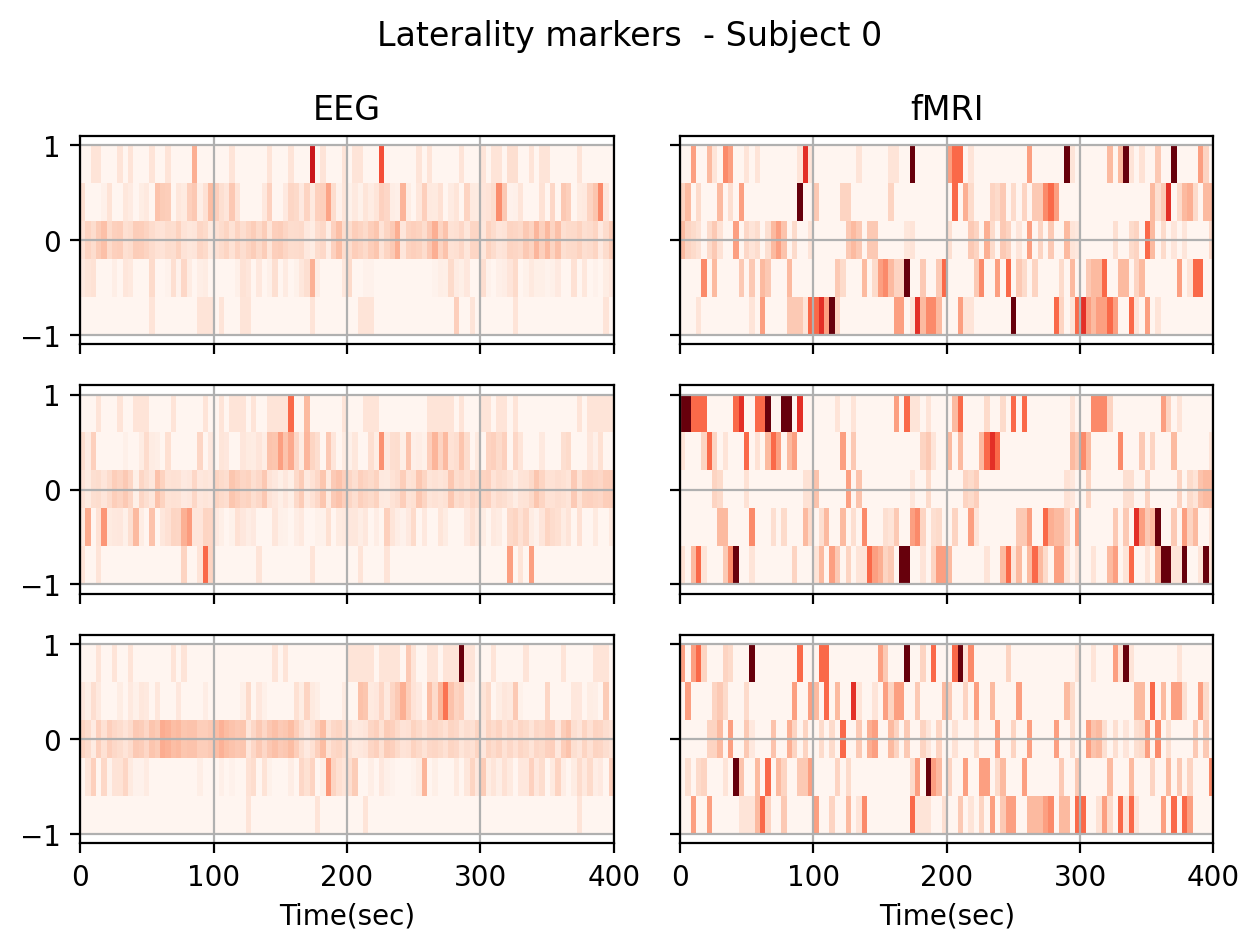

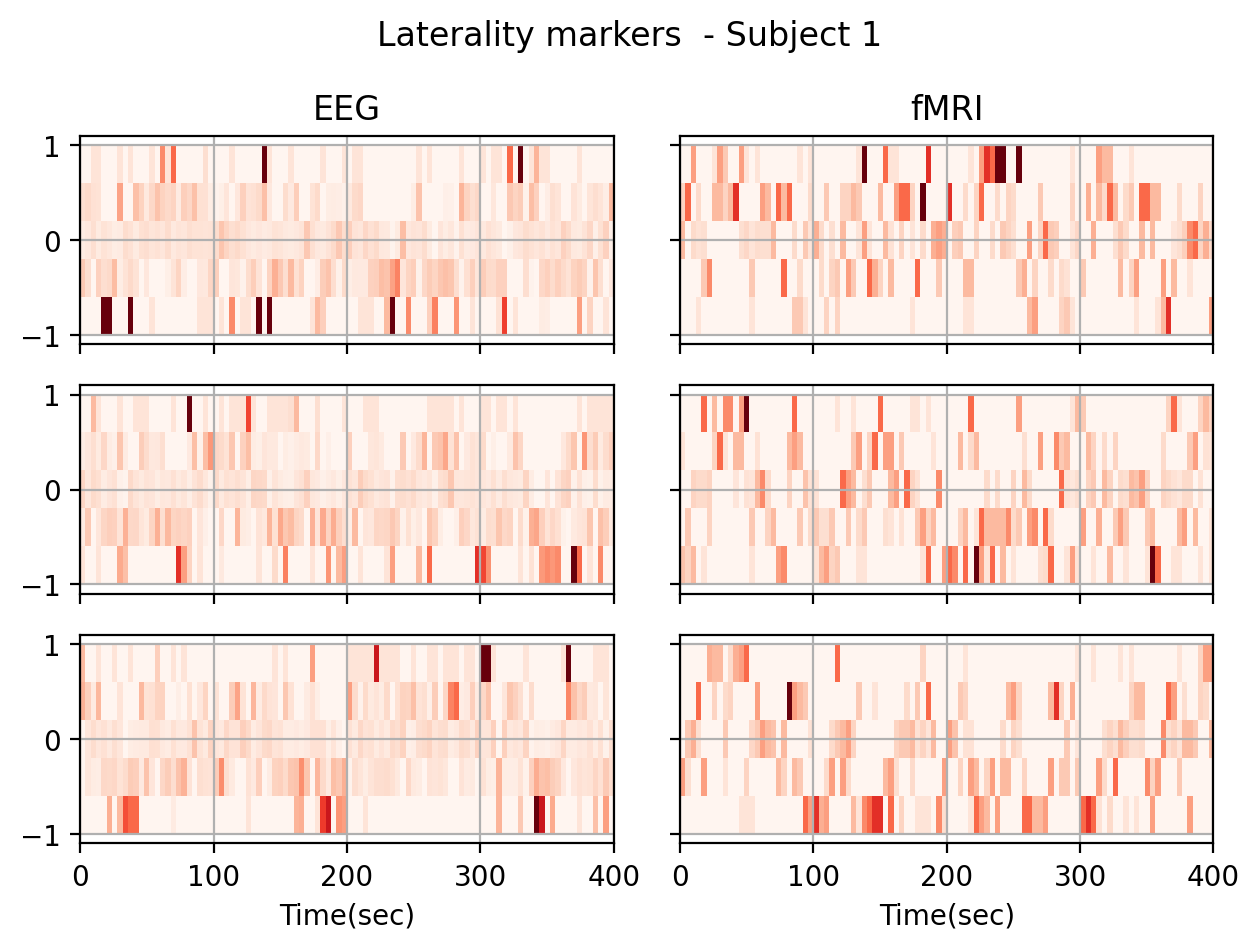

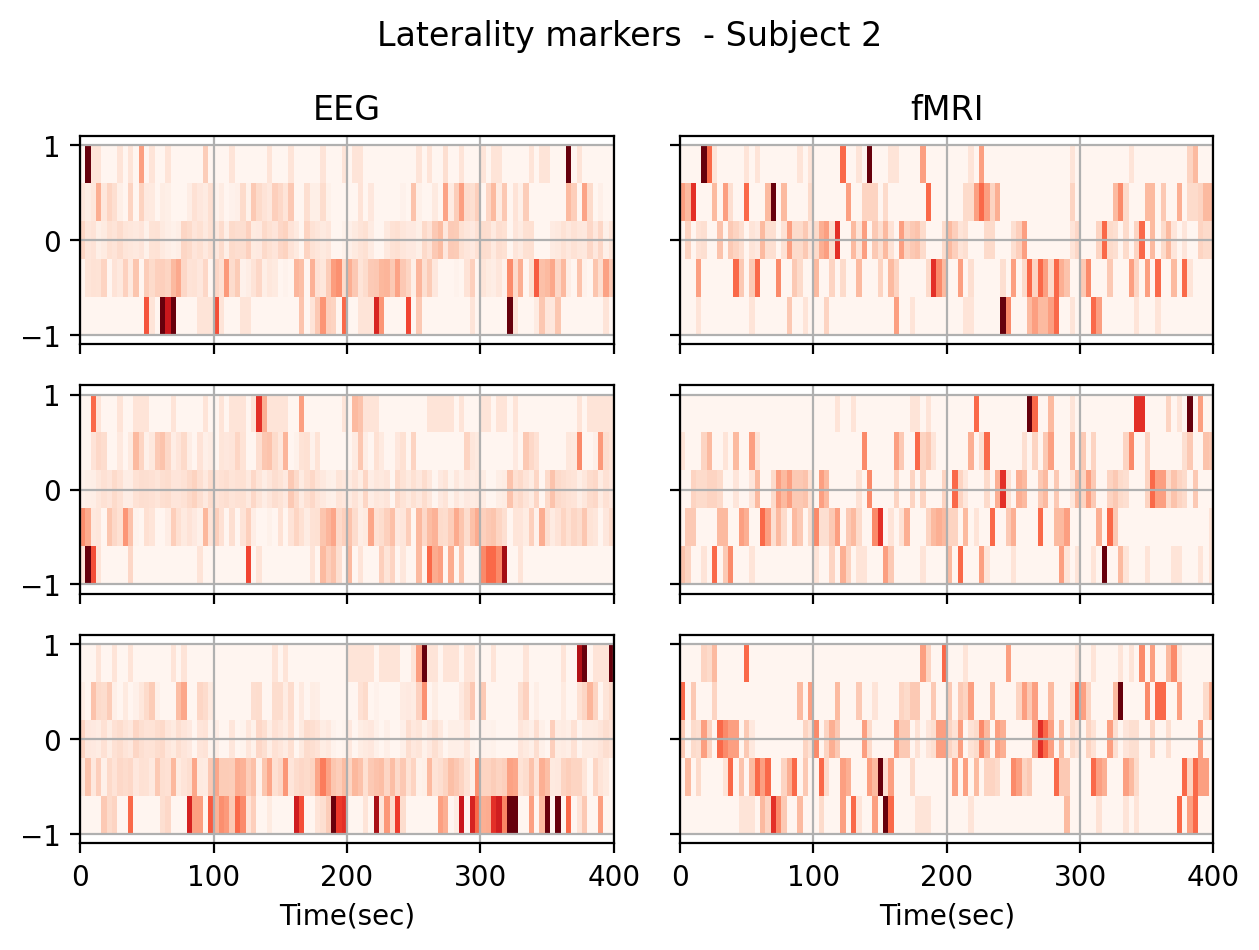

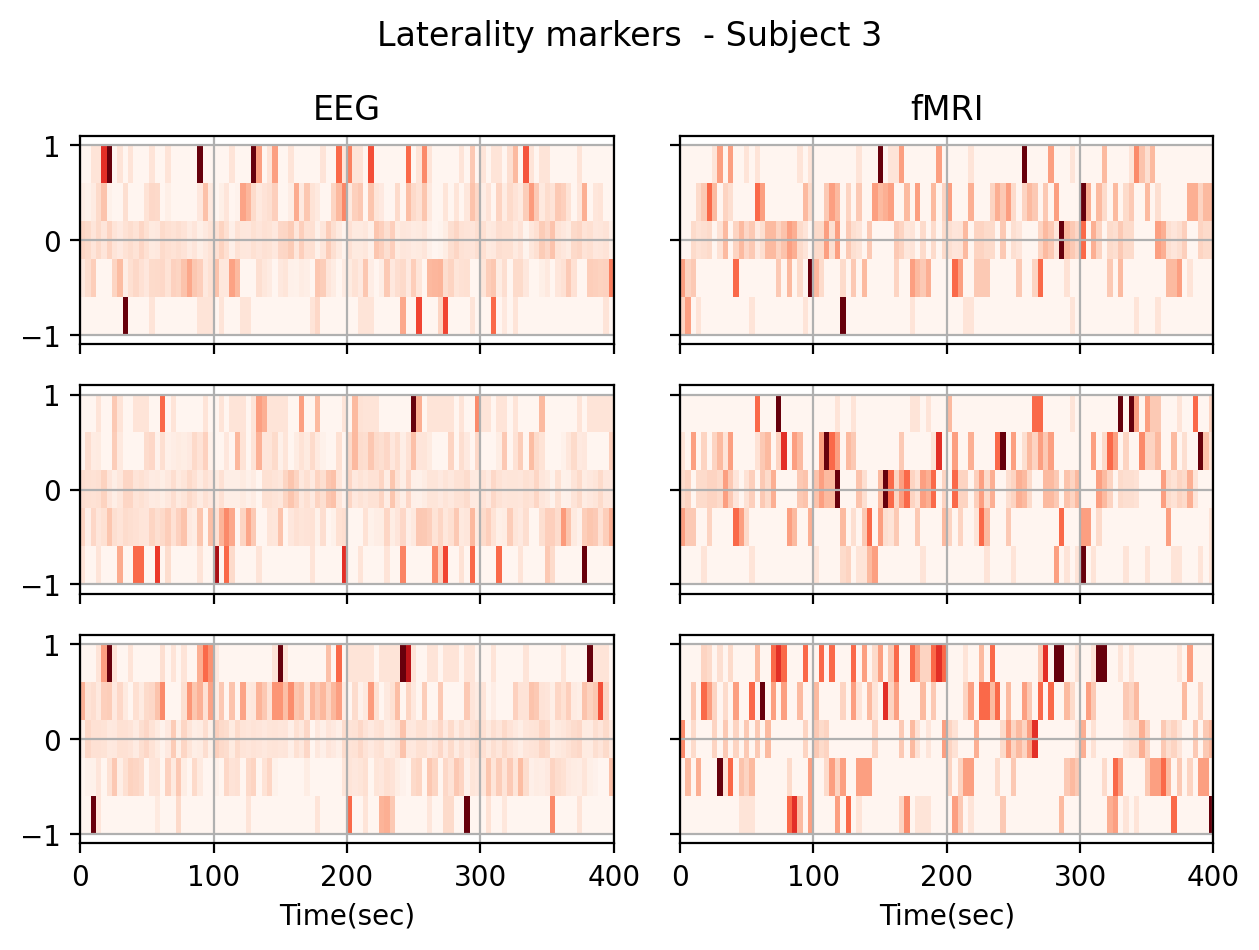

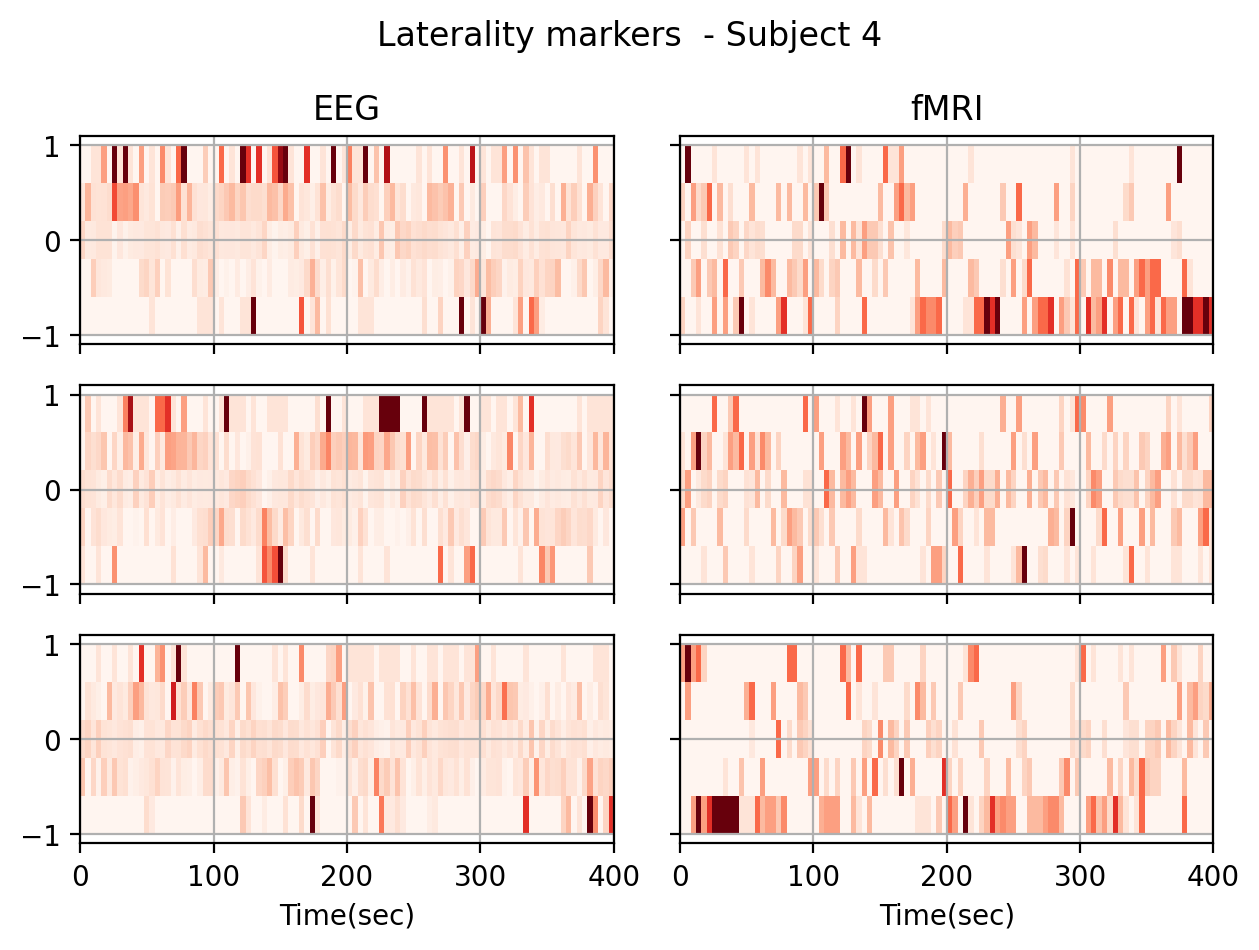

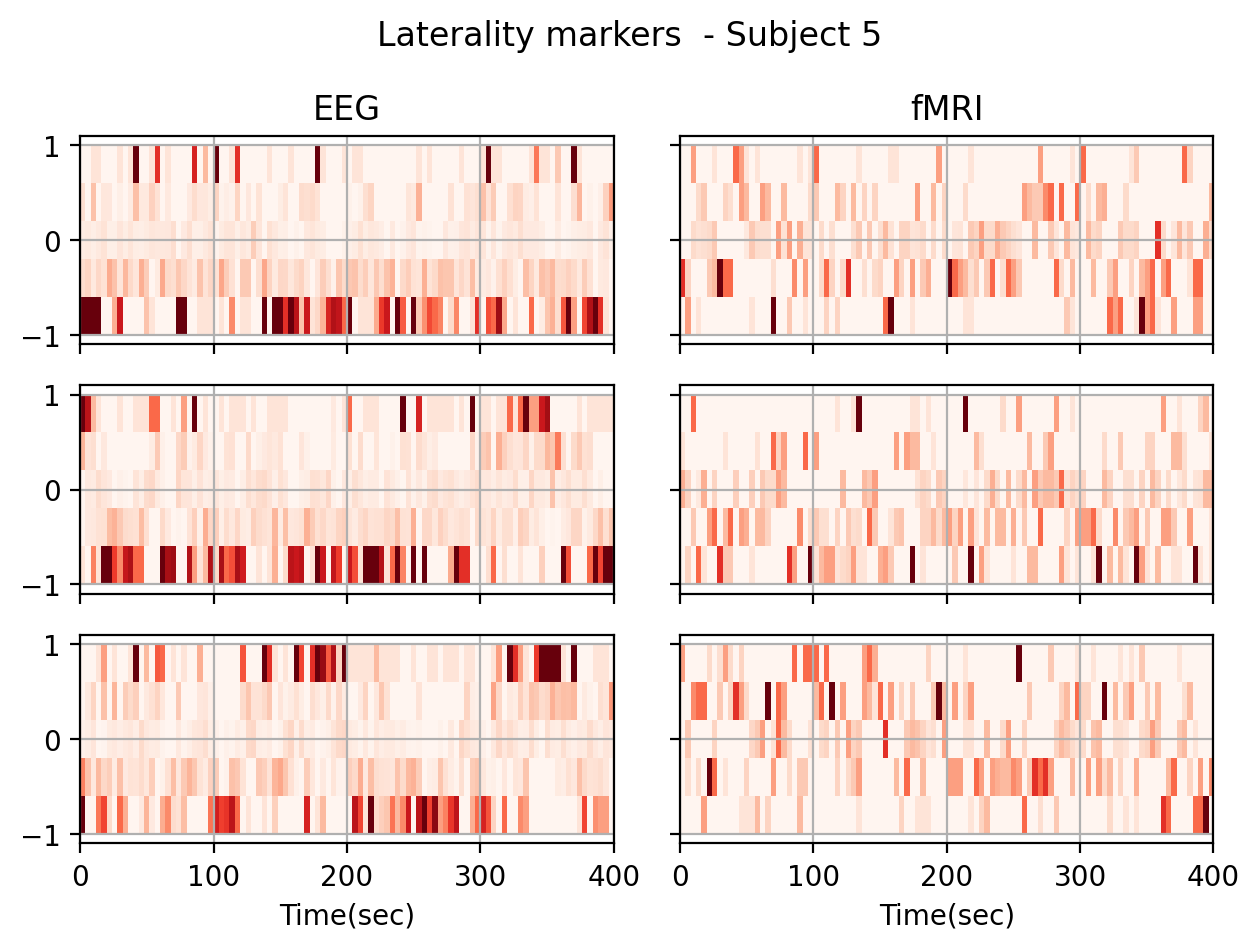

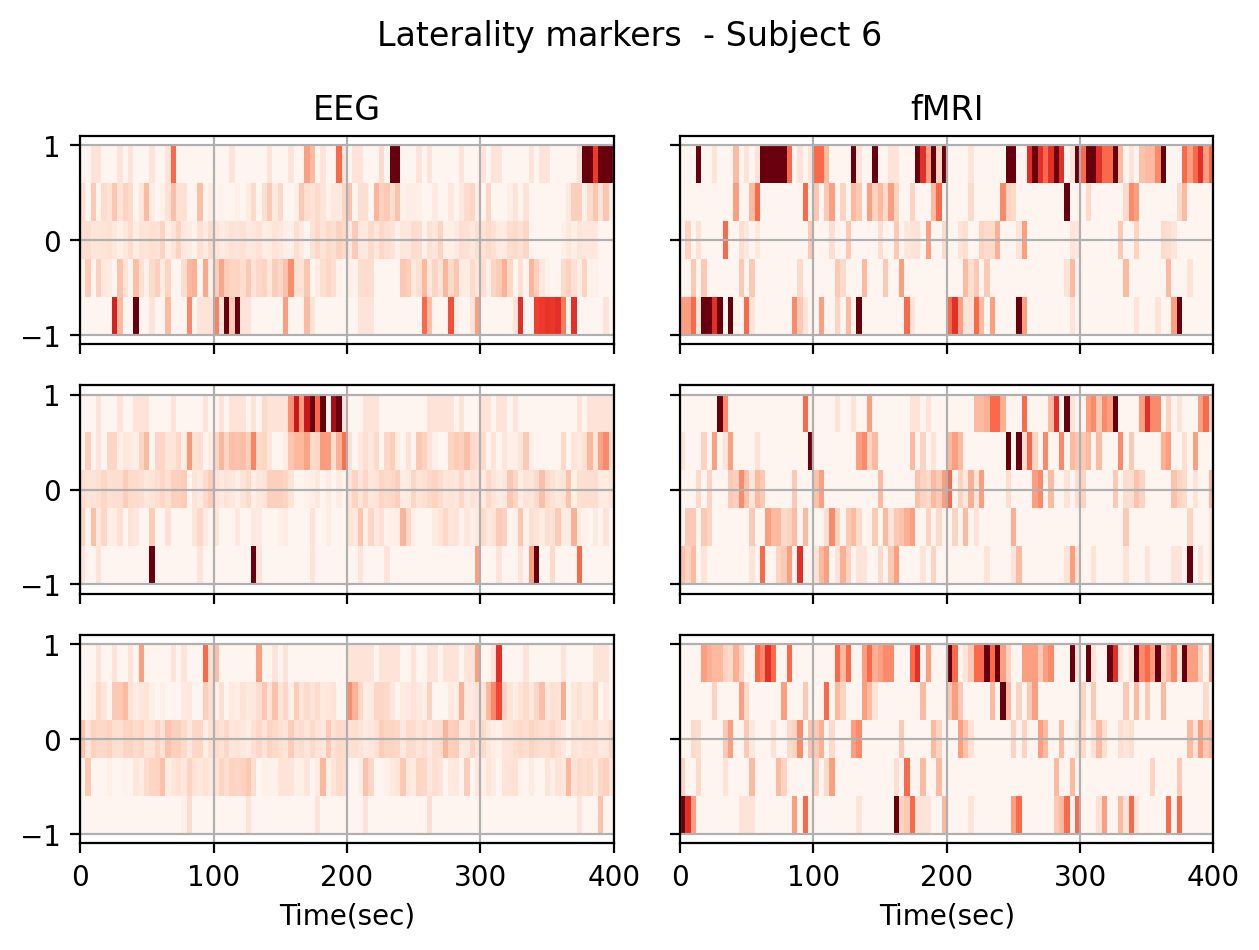

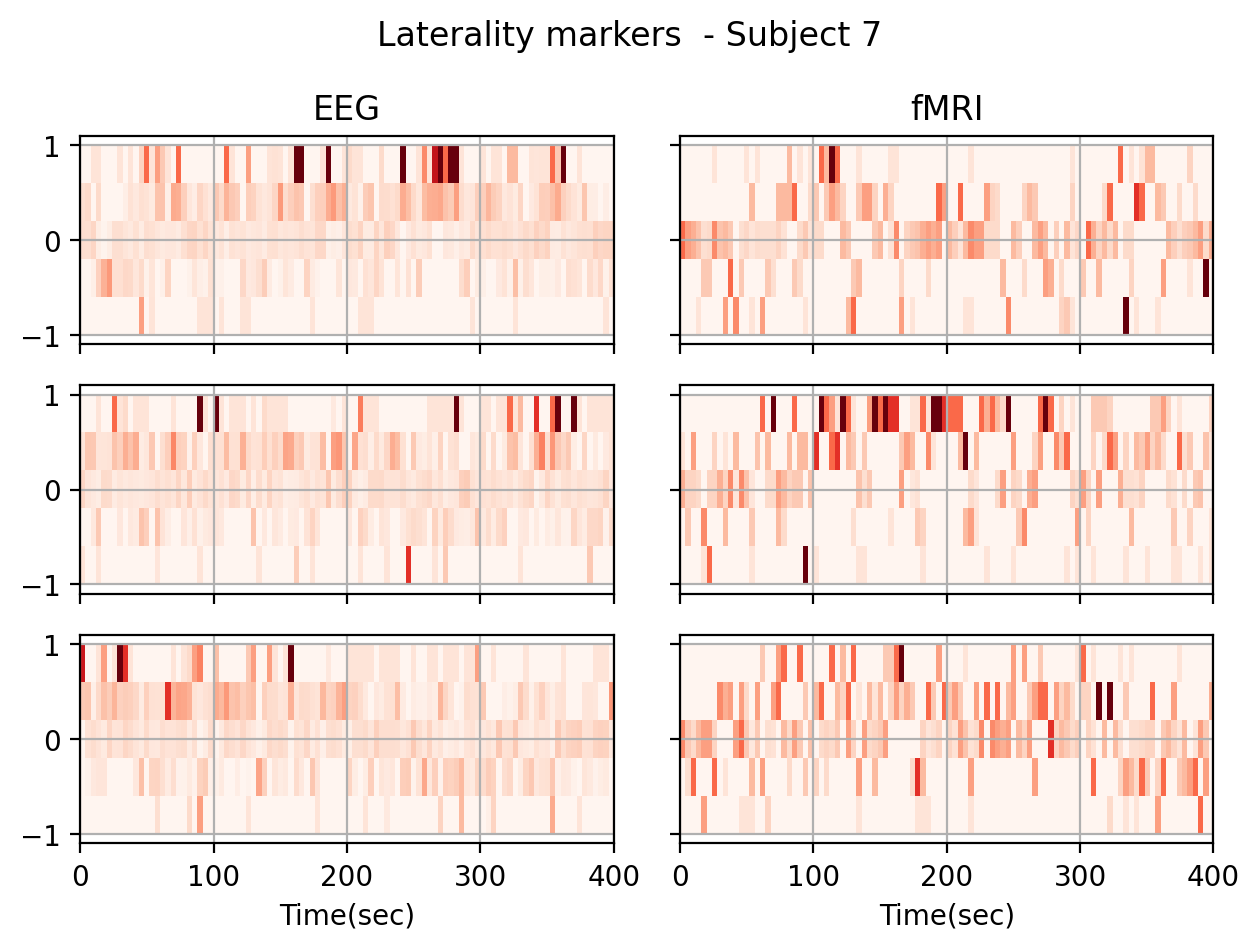

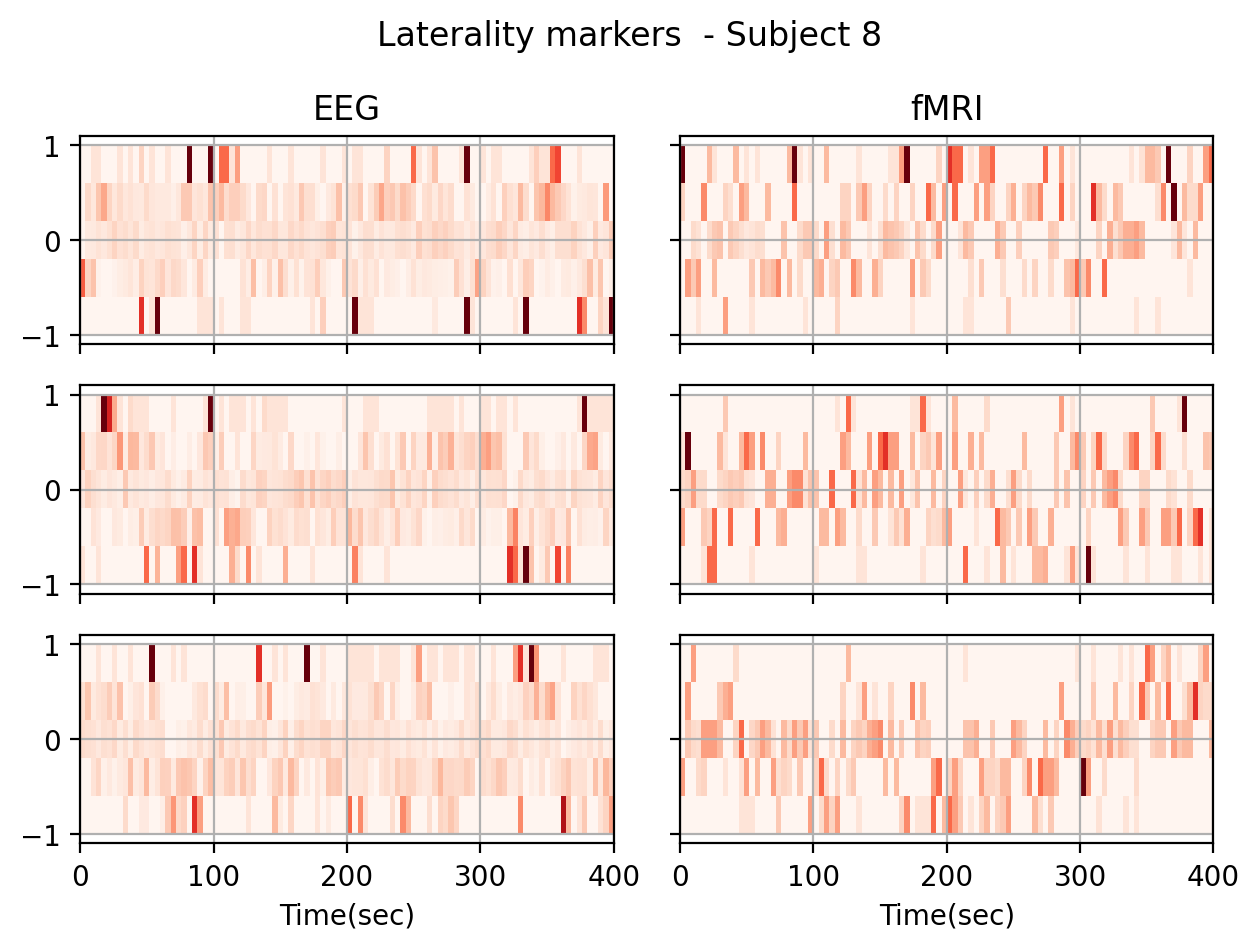

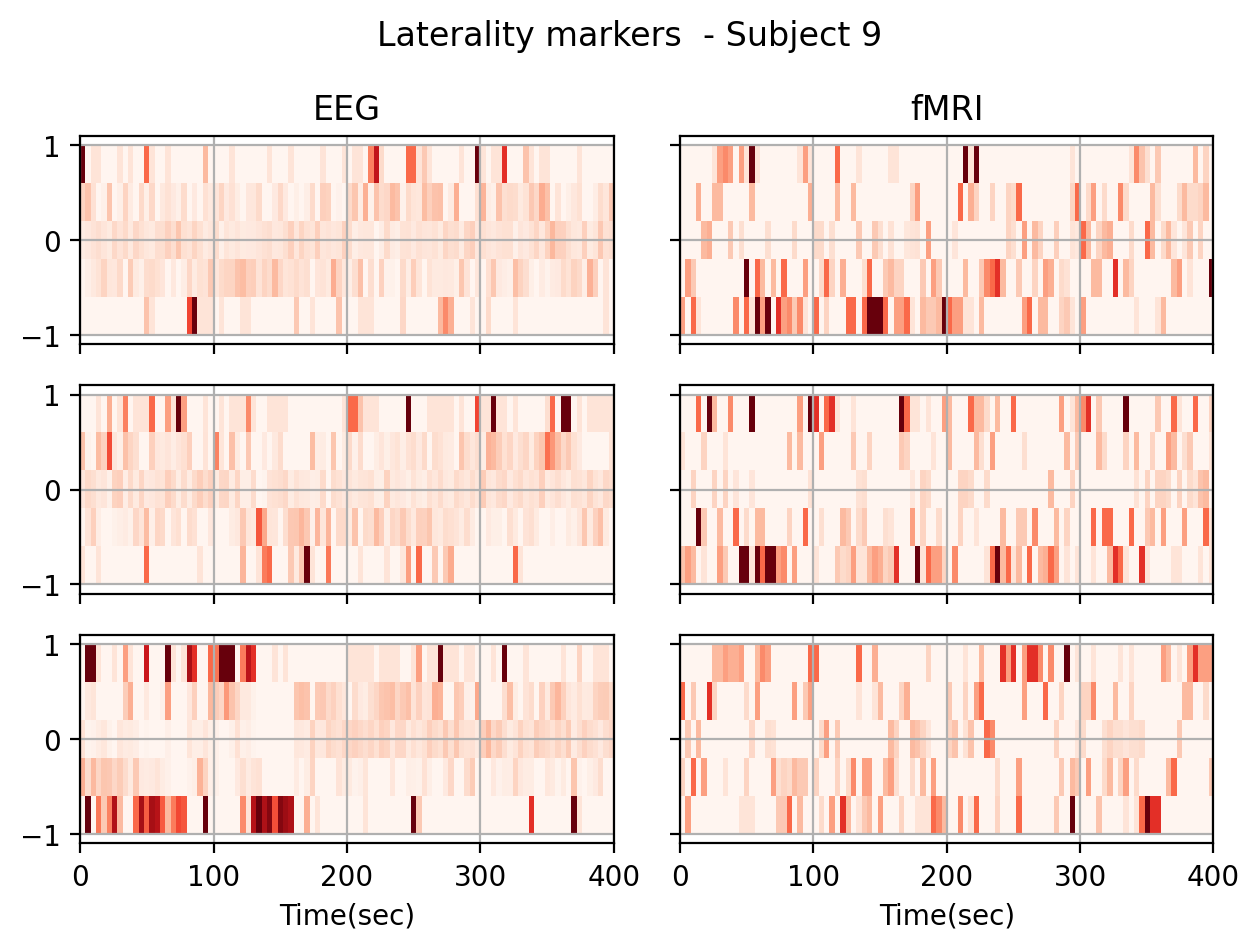

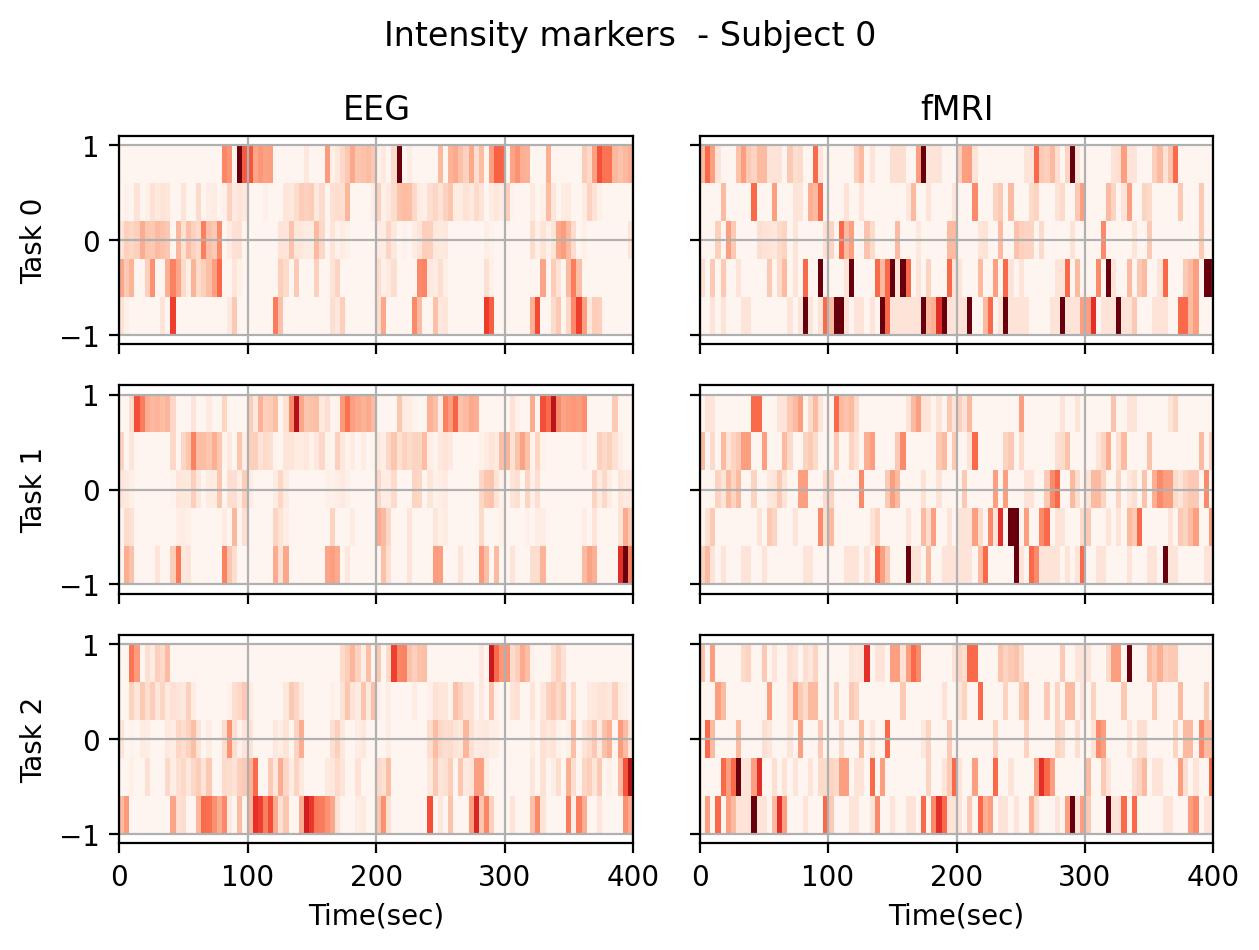

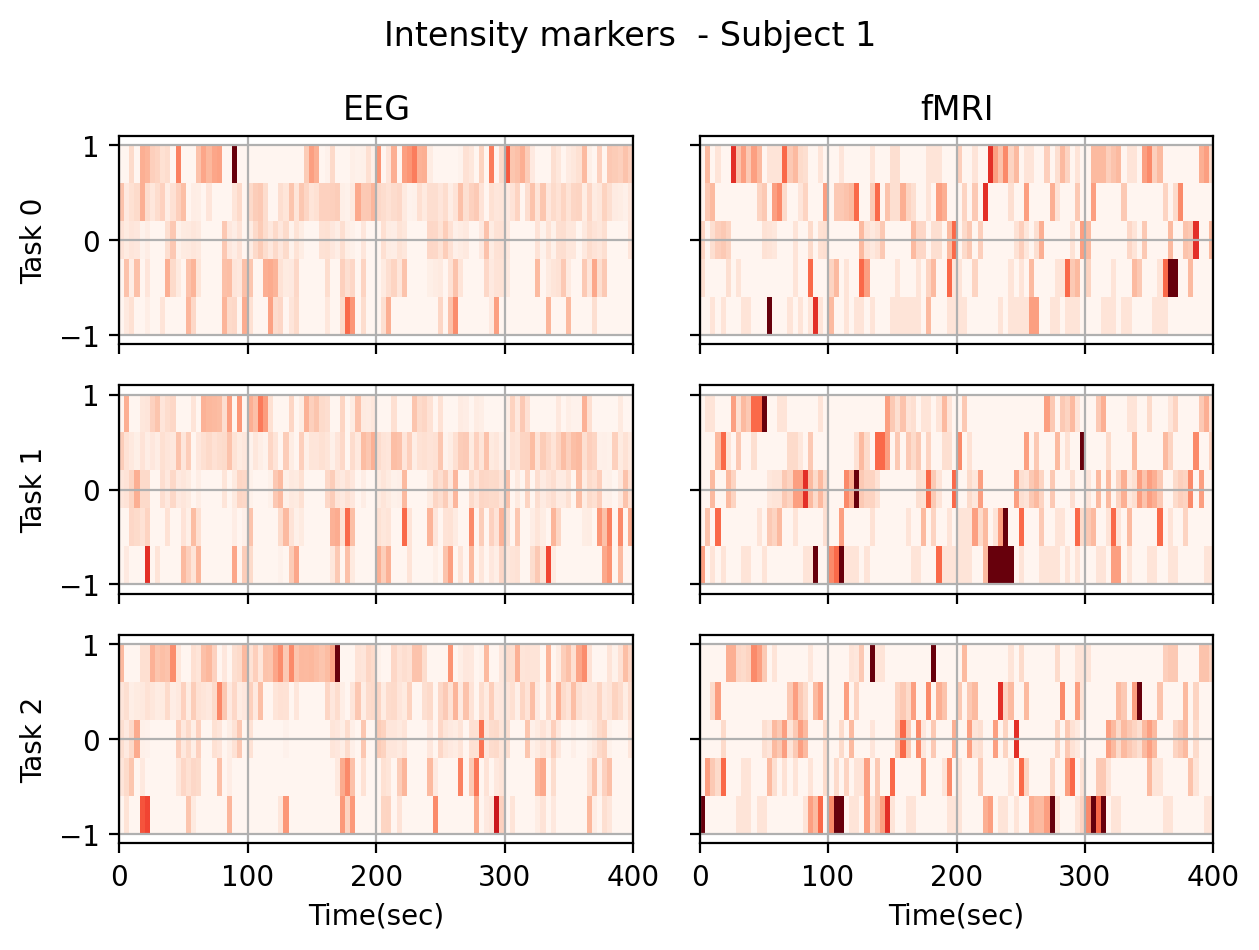

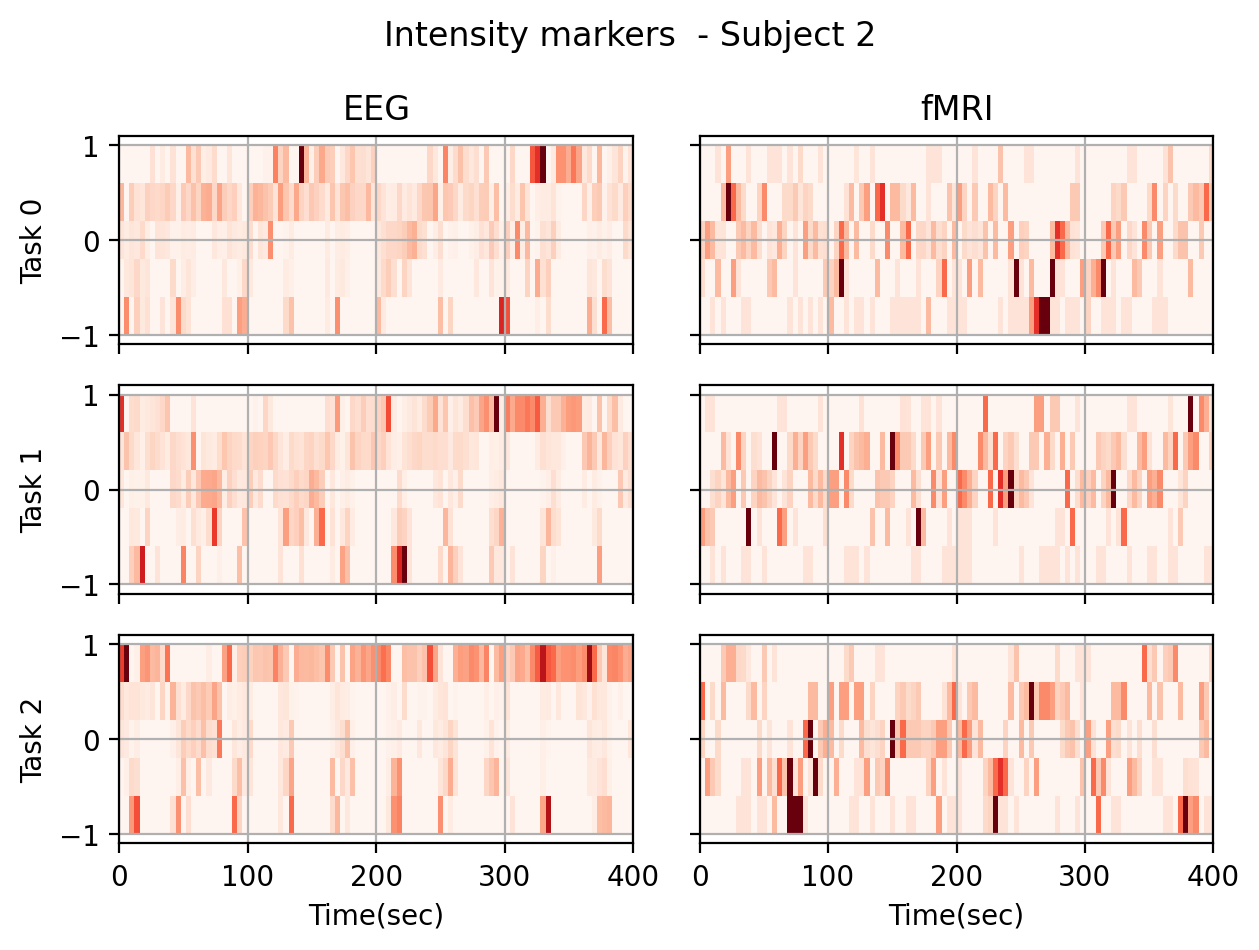

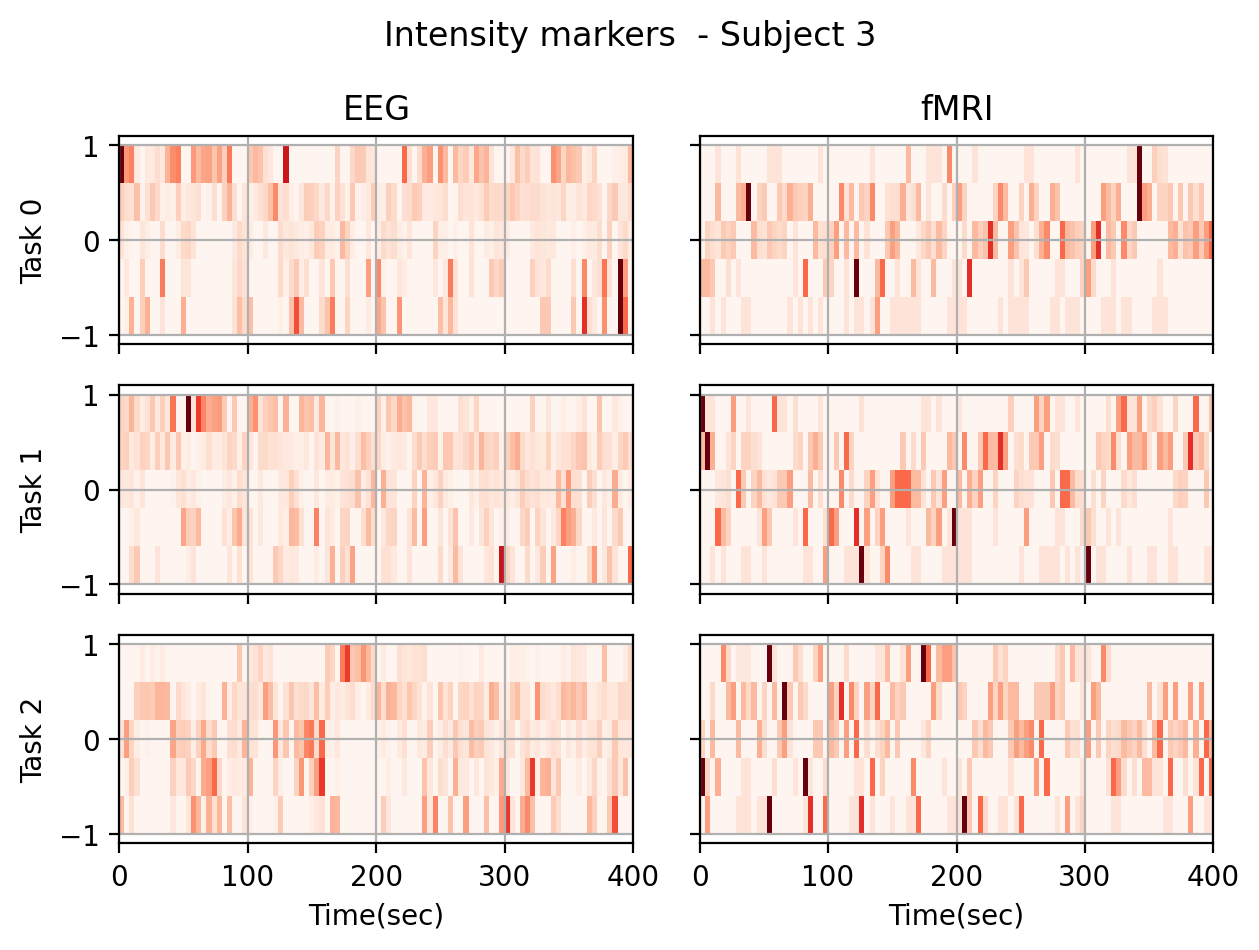

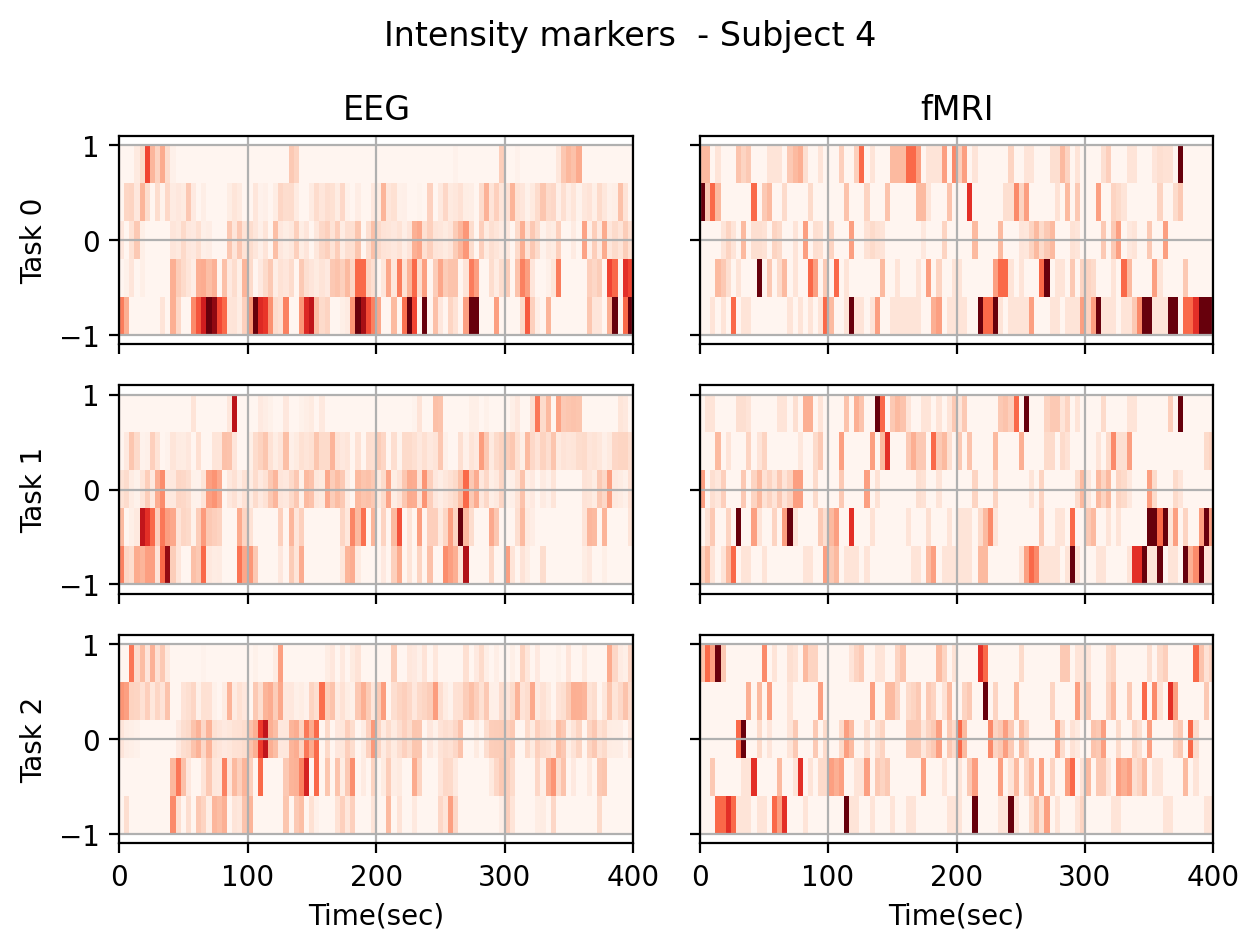

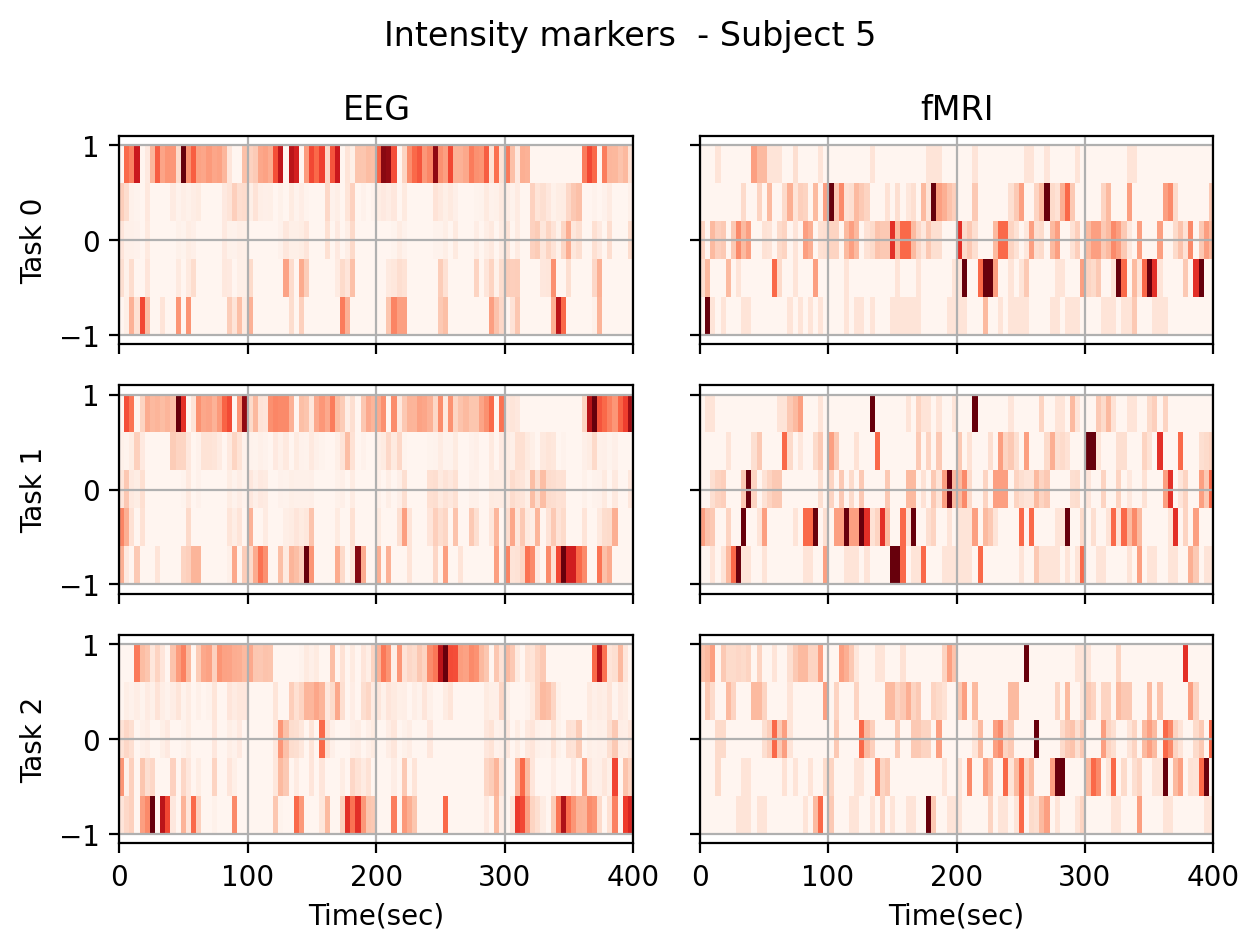

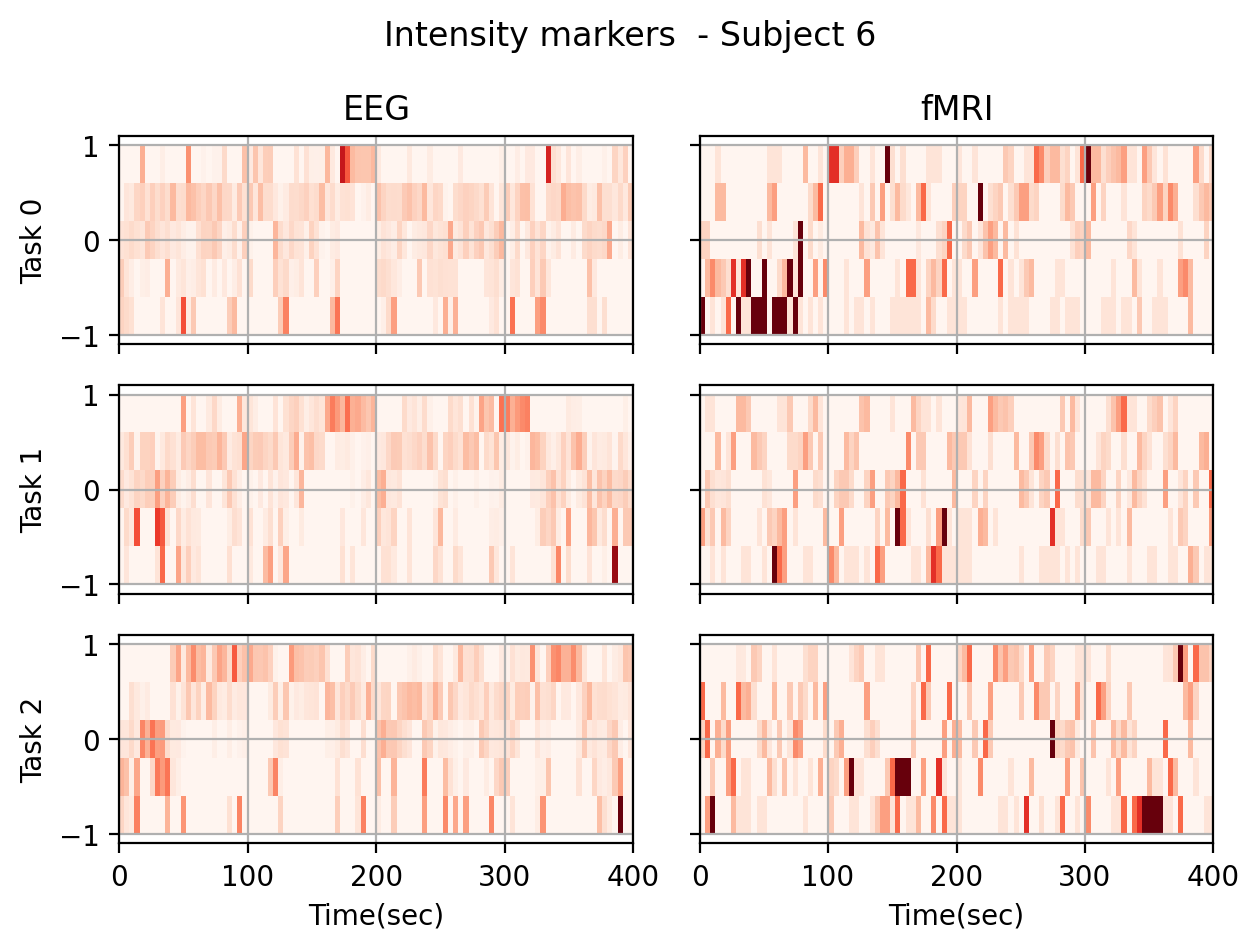

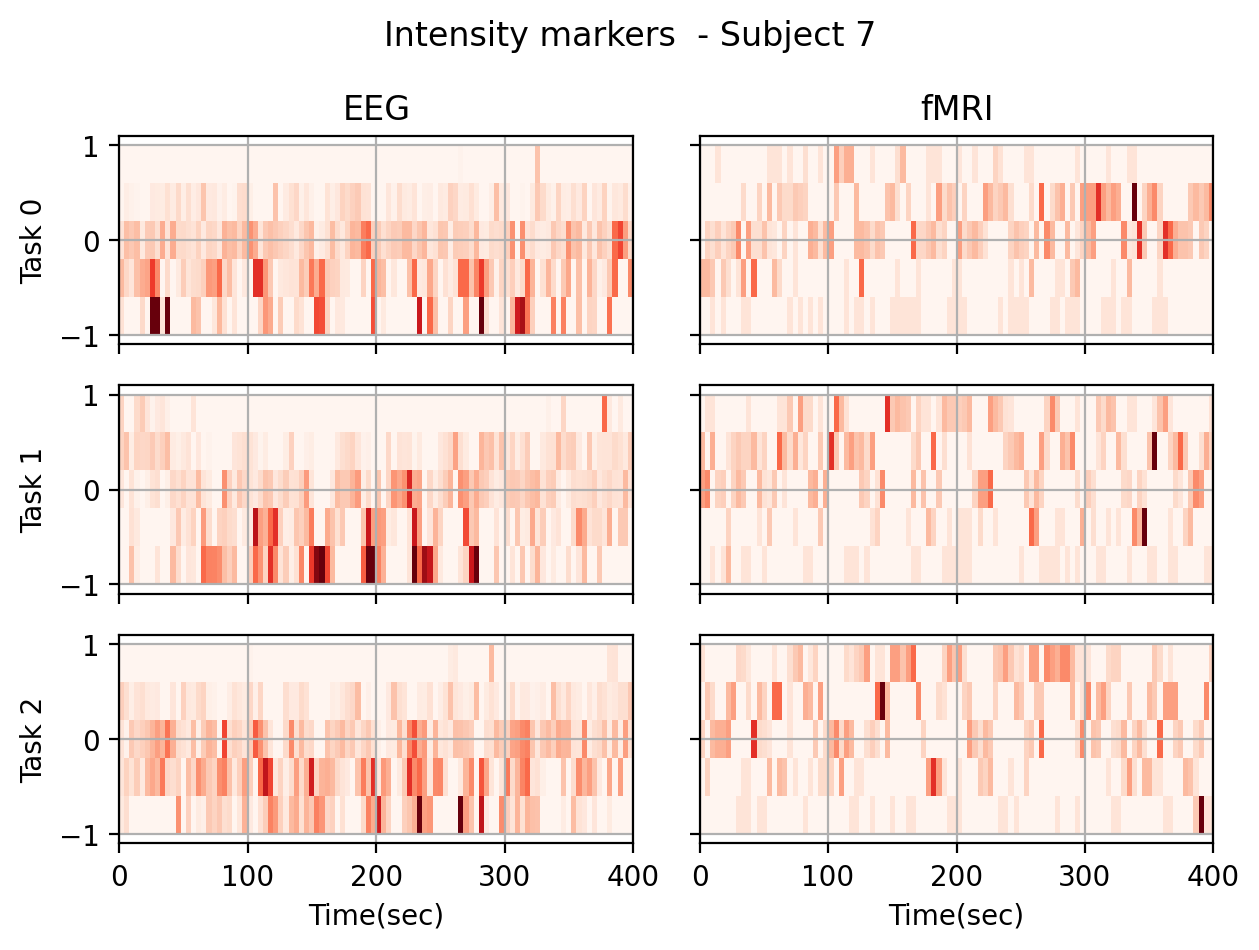

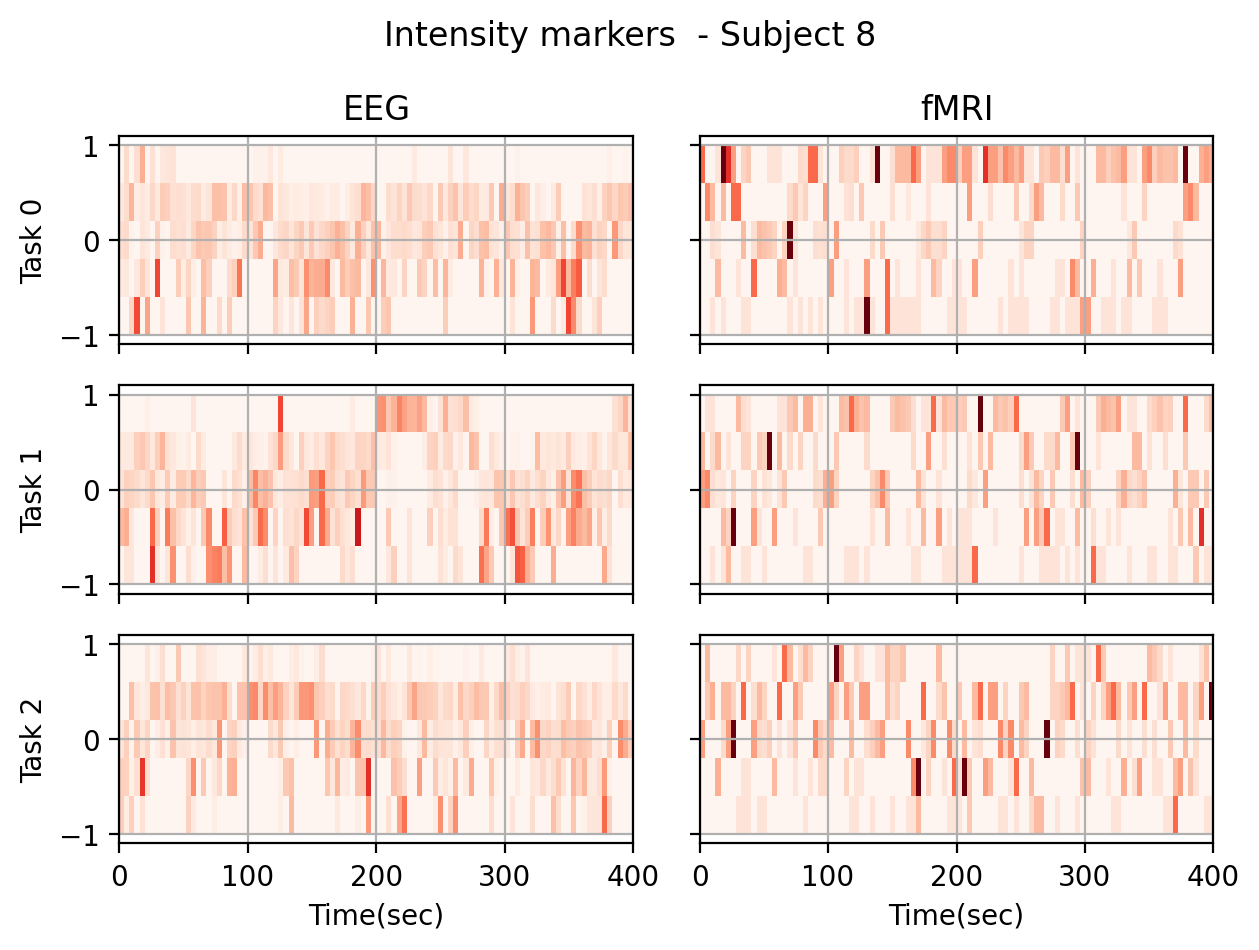

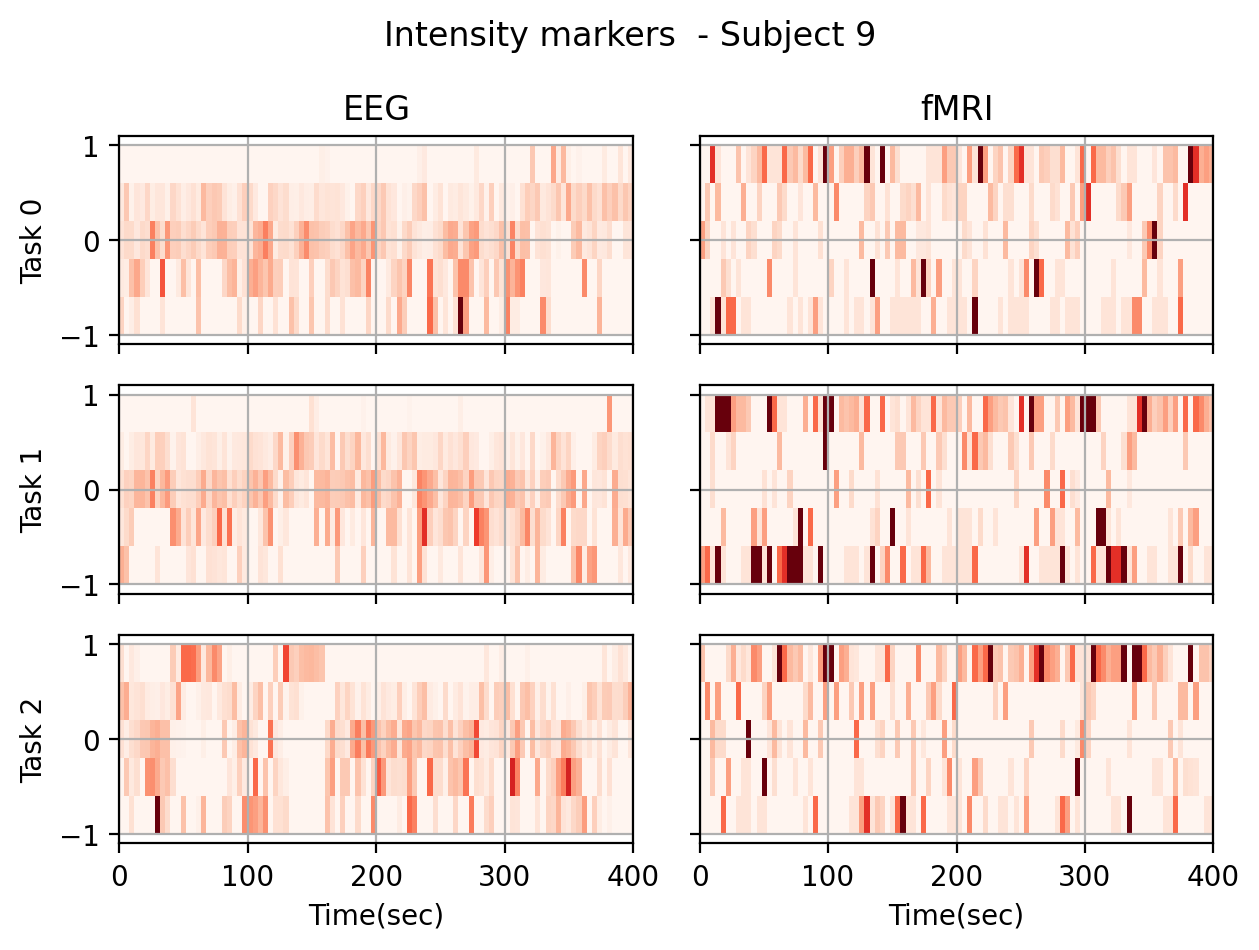

In [ ]:
from load_data import discretize_input

feedback_bins = np.linspace(-1.01,1.01,6)
n_actions_per_run = 5

eeg_feedbacks = np.clip(EEG_LATERALITY_FEEDBACK,-1.0,1.0)[...,0]
bold_feedbacks = np.clip(BOLD_LATERALITY_FEEDBACK,-1.0,1.0)[...,0]
o_eeg_lat,bin_eeg_lat = discretize_input(eeg_feedbacks,feedback_bins,n_actions_per_run)
o_bold_lat,bin_bold_lat = discretize_input(bold_feedbacks,feedback_bins,n_actions_per_run)

erd_intensity_eeg = np.clip(EEG_INTENSITY_LEFT_ERD,-1.0,1.0)[...,0]
erd_intensity_bold = np.clip(BOLD_INTENSITY_LEFT_ERD,-1.0,1.0)[...,0]
o_eeg_int,bin_eeg_int = discretize_input(erd_intensity_eeg,feedback_bins,n_actions_per_run)
o_bold_int,bin_bold_int = discretize_input(erd_intensity_bold,feedback_bins,n_actions_per_run)

print(erd_intensity_eeg.shape)

alpha_val = 0.0

# Laterality plot :
for subj in range(bold_feedbacks[...,0].shape[0]):
    fig,axes = plt.subplots(3,2,sharex=True,sharey=True,dpi=200)
    fig.suptitle("Laterality markers  - Subject {}".format(subj))
    
    axes[0,0].set_title("EEG")
    axes[0,1].set_title("fMRI")
    axes[-1,0].set_xlabel("Time(sec)")
    axes[-1,1].set_xlabel("Time(sec)")
    
    for task in range(bold_feedbacks[...,0].shape[1]) : 
        timestamps_task = timestamps_arr[subj,task,...]
        
        # EEG PLOT 
        ax_eeg = axes[task,0]
        N_eeg_data = eeg_feedbacks[subj,task].shape[0]
        eeg_time = np.linspace(0,400.0,N_eeg_data) 
        
        flat_img = np.swapaxes(np.reshape(o_eeg_lat[subj,task,...],(-1,o_eeg_lat.shape[-1])),0,1)
        flipped = np.flip(flat_img,axis=0)
        ax_eeg.imshow(flipped,extent=[0,400,-1.0,1.0], aspect="auto",interpolation="nearest",cmap="Reds",vmax=1.0,vmin=0.0)
        
        ax_eeg.scatter(eeg_time,eeg_feedbacks[subj,task],s=1.0,alpha=alpha_val)
        ax_eeg.set_ylim([-1.1,1.1])
        ax_eeg.grid()
        
        # BOLD PLOT :
        ax_bold = axes[task,1]
        N_bold_data = bold_feedbacks[subj,task].shape[0]
        bold_time = np.linspace(0,400.0,N_bold_data)
        flat_img = np.swapaxes(np.reshape(o_bold_lat[subj,task,...],(-1,o_bold_int.shape[-1])),0,1)     
        flipped = np.flip(flat_img,axis=0)
        ax_bold.imshow(flipped,extent=[0,400,-1.0,1.0], aspect="auto",interpolation="nearest",cmap="Reds",vmax=1.0,vmin=0.0)
        ax_bold.scatter(bold_time,bold_feedbacks[subj,task],s=4.0,alpha=alpha_val)
        ax_bold.set_ylim([-1.1,1.1])
        ax_bold.grid()
    fig.tight_layout()
    fig.show()
    
# Intensity plot :
for subj in range(bold_feedbacks[...,0].shape[0]):
    fig,axes = plt.subplots(3,2,sharex=True,sharey=True,dpi=200)
    fig.suptitle("Intensity markers  - Subject {}".format(subj))
    
    axes[0,0].set_title("EEG")
    axes[0,1].set_title("fMRI")
    axes[-1,0].set_xlabel("Time(sec)")
    axes[-1,1].set_xlabel("Time(sec)")
    
    for task in range(bold_feedbacks[...,0].shape[1]) : 
        axes[task,0].set_ylabel("Task {}".format(task))
        
        timestamps_task = timestamps_arr[subj,task,...]
        
        # EEG PLOT 
        ax_eeg = axes[task,0]
        N_eeg_data = eeg_feedbacks[subj,task].shape[0]
        eeg_time = np.linspace(0,400.0,N_eeg_data) 
        
        flat_img = np.swapaxes(np.reshape(o_eeg_int[subj,task,...],(-1,o_eeg_int.shape[-1])),0,1)
        flipped = np.flip(flat_img,axis=0)
        ax_eeg.imshow(flipped,extent=[0,400,-1.0,1.0], aspect="auto",interpolation="nearest",cmap="Reds",vmax=1.0,vmin=0.0)
        
        ax_eeg.scatter(eeg_time,erd_intensity_eeg[subj,task],s=1.0,alpha=alpha_val)
        ax_eeg.set_ylim([-1.1,1.1])
        ax_eeg.grid()
        
        # BOLD PLOT :
        ax_bold = axes[task,1]
        N_bold_data = bold_feedbacks[subj,task].shape[0]
        bold_time = np.linspace(0,400.0,N_bold_data)
        flat_img = np.swapaxes(np.reshape(o_bold_int[subj,task,...],(-1,o_bold_int.shape[-1])),0,1)     
        flipped = np.flip(flat_img,axis=0)
        ax_bold.imshow(flipped,extent=[0,400,-1.0,1.0], aspect="auto",interpolation="nearest",cmap="Reds",vmax=1.0,vmin=0.0)
        ax_bold.scatter(bold_time,erd_intensity_bold[subj,task],s=4.0,alpha=alpha_val)
        ax_bold.set_ylim([-1.1,1.1])
        ax_bold.grid()
    fig.tight_layout()
    fig.show()

In [ ]:



print(o_bold_lat.shape)
print(o_bold_int.shape)


# import jax.numpy as jnp
subj,task,run = 1,1,1

bold_grid = np.einsum("strai,straj->straij",o_bold_int,o_bold_lat) # subject x task x run x action x (intensity x laterality)
eeg_grid = np.einsum("strai,straj->straij",o_eeg_int,o_eeg_lat) # subject x task x run x action x (intensity x laterality)
# t = 0
# for t in range(5):
#     grid = jnp.einsum("i,j->ij",o_bold_int[subj,task,run,t],o_bold_lat[subj,task,run,t])
#     grid = jnp.einsum("i,j->ij",o_eeg_int[subj,task,run,t],o_eeg_lat[subj,task,run,t])
#     print(grid)
#     plt.imshow(grid,vmin=0,vmax=1)
#     plt.show()

mean_eeg_grid = eeg_grid[0,...]# np.mean(eeg_grid,axis=0)
mean_eeg_grid = np.mean(bold_grid,axis=0)

from PIL import Image

gif_list = []
for task in range(mean_eeg_grid.shape[0]):
    for run in range(mean_eeg_grid.shape[1]):
        for action in range(mean_eeg_grid.shape[2]):
            gif_list.append(mean_eeg_grid[task,run,action])
            # grid = jnp.einsum("i,j->ij",o_bold_int[subj,task,run,t],o_bold_lat[subj,task,run,t])
            # grid = jnp.einsum("i,j->ij",o_eeg_int[subj,task,run,t],o_eeg_lat[subj,task,run,t])

imgs = [Image.fromarray((arr*255).astype(int)).resize((400,400)) for arr in gif_list] 
imgs[0].save("array.gif", save_all=True, append_images=imgs[1:], duration=150, loop=0)

print(len(imgs))

(10, 3, 20, 10, 4)
(10, 3, 20, 10, 4)
600
